# Plano atual do projeto:

1ª semana) Análise exploratória: olhar dados estruturados e observar tendências e sua lógica. Ex.: localização, nº candidatos, tipo de local de trabalho, habilidades requeridas, nível da vaga, setor da companhia.

2ª semana) Uso de NLP (BerTopic): modelo de tópicos usado com os dados do campo description
- https://maartengr.github.io/BERTopic/index.html

3ª semana) Análise cruzada entre tópicos mapeados com NLP e a análise exploratória / Uso de Langchain para categorizar e possivelmente corrigir nomes de posições inadequadas conforme a análise
- https://python.langchain.com/en/latest/

In [173]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [174]:
# Obtaining the data from all the archives extracted from Linkedin
df_jobs = pd.DataFrame()
for job in os.listdir('data'):
    if job[-4:] == '.csv':
        new_df = pd.read_csv(f'data/{job}', sep=';')
        df_jobs = pd.concat([df_jobs, new_df], axis=0)

# Initial Analysis

In [175]:
print(df_jobs.info())

<class 'pandas.core.frame.DataFrame'>
Index: 4486 entries, 0 to 937
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   position                4486 non-null   object 
 1   company                 4486 non-null   object 
 2   location                4486 non-null   object 
 3   posted_date             4482 non-null   object 
 4   no_applicants           3016 non-null   object 
 5   date_collected          4486 non-null   object 
 6   type_workplace          3877 non-null   object 
 7   required_skills         4269 non-null   object 
 8   competitive_advantages  0 non-null      float64
 9   level                   3766 non-null   object 
 10  worktype                4486 non-null   object 
 11  description             4486 non-null   object 
 12  link_application        4486 non-null   object 
 13  link_linkedin           4486 non-null   object 
 14  company_name            4482 non-null   object

This dataset has 4486 entries, most of which are fully filled. There is an entire blank column ('competitive advantages') and the remaining columns are all of the Dtype 'object', requiring conversion. There are a few NA values in the 'posted_date' and 'company_name' columns, which can be removed for better data integrity. We should analyse the remaining ones to decide what to do about the null values.

In [176]:
df_jobs.describe()

,competitive_advantages
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


Since the .describe() method returns only the numerical columns when they are available and the only numerical column is entirely empty, let us refine our search with the argument 'exclude=np.number'

In [177]:
df_jobs.describe(exclude=np.number).T

,count,unique,top,freq
position,4486,1850,Sports Statistician,72
company,4486,1099,"{'name': 'Turing', 'size': '1.001-5.000 funcio...",136
location,4486,240,"São Paulo, São Paulo, Brasil",1275
posted_date,4482,4425,2023-05-29 18:14:56.584167,22
no_applicants,3016,199,15 candidaturas,50
date_collected,4486,4429,2023-06-05 18:14:56.597077,22
type_workplace,3877,3,Presencial,1638
required_skills,4269,2057,"['Esportes', 'Futebol americano', 'Internet Ac...",50
level,3766,8,Pleno-sênior,1961
worktype,4486,16,Tempo integral,4160


Most of the columns is very diverse, which difficults initial categorization. There are 1850 names for positions, though the dataset is the result of a data extraction of the results of the query 'Data Analyst'. It shouldn't have so many different job positions, only a few. There are some other considerations to be done about the name of the position - namely, that it does not define a lot, since data analysts are pretty much a loosely defined occupation, mixing with data engineering, data scientist, among others.

'location' brings city, state and country, which can be better analysed in different columns. We will make this transformation futurely. We will also transform the column 'no_applicants', so it can be a numerical column. 'date_collected' and 'posted_date' will be converted to datetime (so far, there are only 'object' dtype columns), and the latter will have the hour, minute, and so on ommited. The reason for that is that the data extractor is not that precise, it is just an estimative, but having that much info gives an illusion of precision.

We can already notice that some values are impressively present in the dataset. 1275 records are from 'São Paulo, São Paulo, Brasil'; 1638 records of the type of the workplace are 'Presencial'; 1961 records of the level of the job position is 'Pleno-sênior'; and 4160 - almost all of the dataset - is 'Tempo Integral' worktype. Company_size and company_sector also have this disbalance.

Another interesting thing we can already infer from the dataset is the presence of repeated descriptions. This is worth mentioning because it is a text extracted integrally from Linkedin, which means it is position-specific. The 48 repeated positions, which appear to be related with sports, imply that there are positions with the exact same description. Why is that? Probably, it is the same position opened for different locations, but there could be another explanation.

'link_application' will be transformed so we can group the jobs which application is made in the same platform.
'link_linkedin' is not very relevant to us.

'company_size' requires transformation for better usage, but it might not be very relevant for the analysis we are interested.



In [178]:
df_jobs.head()

,position,company,location,posted_date,no_applicants,date_collected,type_workplace,required_skills,competitive_advantages,level,worktype,description,link_application,link_linkedin,company_name,company_size,company_sector
0,Analista de Gestão de Dados,"{'name': 'Moove', 'size': '1.001-5.000 funcion...","São Paulo, São Paulo, Brasil",2023-06-02 15:06:50.791991,NaN,2023-06-05 15:06:50.800990,Híbrido,"['SQL', 'Alteryx', 'Azure Data Factory', 'Azur...",NaN,NaN,Tempo integral,Sobre a vaga\nPosição: Analista de Gestão de D...,https://www.linkedin.com/jobs/view/3624224677/...,https://www.linkedin.com/jobs/view/3624224677/...,Moove,1.001-5.000 funcionários,NaN
1,Marketing Data Analyst,"{'name': 'Valtech', 'size': '5.001-10.000 func...",São Paulo e Região,2023-05-29 15:06:57.048773,77 candidaturas,2023-06-05 15:06:57.059778,NaN,"['Analítica', 'Analítica de dados', 'Análise d...",NaN,Pleno-sênior,Tempo integral,Sobre a vaga\nA Valtech é uma Agência Digital ...,https://careers.brazil.valtech.com/jobs/272791...,https://www.linkedin.com/jobs/view/3613520213/...,Valtech,5.001-10.000 funcionários,Serviços e consultoria de TI
2,Football Statistician,"{'name': 'Genius Sports', 'size': '1.001-5.000...","Crateús, Ceará, Brasil",2023-05-29 15:07:01.909347,47 candidaturas,2023-06-05 15:07:01.919349,Presencial,"['Esportes', 'Futebol americano', 'Inglês', 'I...",NaN,Assistente,Contrato,Sobre a vaga\nLove sports?\n\nWe're looking fo...,https://boards.greenhouse.io/geniussports/jobs...,https://www.linkedin.com/jobs/view/3580156456/...,Genius Sports,1.001-5.000 funcionários,Desenvolvimento de software
3,­­­Analista Privacidade de Dados Sr – Prazo De...,"{'name': 'CPFL Energia', 'size': '5.001-10.000...","Campinas, São Paulo, Brasil",2023-05-29 15:07:15.555500,98 candidaturas,2023-06-05 15:07:15.567136,Presencial,"['Análise de dados', 'Microsoft Excel', 'Avali...",NaN,NaN,Tempo integral,Sobre a vaga\nAnalista Privacidade de Dados Sr...,https://career19.sapsf.com/sfcareer/jobreqcare...,https://www.linkedin.com/jobs/view/3613286152/...,CPFL Energia,5.001-10.000 funcionários,"Serviços de eletricidade, gás, água e esgoto"
4,ANALISTA CADASTRO JR,"{'name': 'AkzoNobel', 'size': '+ de 10.001 fun...","Mauá, São Paulo, Brasil",2023-06-03 15:07:28.657900,101 candidaturas,2023-06-05 15:07:28.678311,Presencial,"['Comunicação', 'Análise de negócios', 'Aprese...",NaN,NaN,Tempo integral,Sobre a vaga\nSomos pioneiros em um mundo de p...,https://careers.akzonobel.com/job/ANALISTA-CAD...,https://www.linkedin.com/jobs/view/3621326350/...,AkzoNobel,+ de 10.001 funcionários,Fabricação de produtos químicos


In [179]:
df_jobs.tail()

,position,company,location,posted_date,no_applicants,date_collected,type_workplace,required_skills,competitive_advantages,level,worktype,description,link_application,link_linkedin,company_name,company_size,company_sector
933,Developer ServiceNow ITOM/ITAM,"{'name': 'Wipro', 'size': '+ de 10.001 funcion...","São Paulo, Brasil",2023-06-01 08:52:10.098846,69 candidaturas,2023-06-06 08:52:10.117914,Remoto,"['Articulação (TI)', 'CAD', 'Certificação ITIL...",NaN,Pleno-sênior,Tempo integral,"Sobre a vaga\nNós somos a Wipro, uma empresa d...",https://www.linkedin.com/jobs/view/3621704573/...,https://www.linkedin.com/jobs/view/3621704573/...,Wipro,+ de 10.001 funcionários,Serviços e consultoria de TI
934,SRE Specialist,"{'name': 'Dock', 'size': '1.001-5.000 funcioná...",Brasil,2023-05-30 08:52:13.172745,48 candidaturas,2023-06-06 08:52:13.182745,Remoto,['SRE (Engenharia de confiabilidade do site)'],NaN,Assistente,Tempo integral,Sobre a vaga\nJob Description\n\nNa Dock você ...,https://dock.gupy.io/job/eyJzb3VyY2UiOiJndXB5X...,https://www.linkedin.com/jobs/view/3615812605/...,Dock,1.001-5.000 funcionários,Serviços e consultoria de TI
935,Estágio em Desenvolvimento Python,"{'name': '4mti Soluções Ltda.', 'size': 'Veja ...","Belo Horizonte, Minas Gerais, Brasil",2023-05-06 08:52:18.782909,52 candidaturas,2023-06-06 08:52:18.800424,Híbrido,NaN,NaN,Estágio,Tempo integral,Sobre a vaga\nEsta vaga foi obtida de um site ...,https://www.catho.com.br/vagas/linkedin/22518973/,https://www.linkedin.com/jobs/view/3608512751/...,4mti Soluções Ltda.,Veja como você se compara a 52 candidatos. Exp...,NaN
936,Consultor(a) FullStack,"{'name': 'Avanade', 'size': '+ de 10.001 funci...","São Paulo, São Paulo, Brasil",2023-05-23 08:52:32.592300,54 candidaturas,2023-06-06 08:52:32.617668,NaN,"['Comunicação', 'Estruturas de dados', 'Lingua...",NaN,Pleno-sênior,Tempo integral,Sobre a vaga\nJob Description\n\nConsultor(a) ...,https://careers.avanade.com/jobsenus/JobDetail...,https://www.linkedin.com/jobs/view/3588922575/...,Avanade,+ de 10.001 funcionários,Serviços e consultoria de TI
937,Senior Data Engineer - DSP for Vibration Analysis,"{'name': 'TRACTIAN', 'size': '51-200 funcionár...",Brasil,2023-05-16 08:52:41.297504,42 candidaturas,2023-06-06 08:52:41.326710,Remoto,"['NoSQL', 'Python', 'SQL', 'Amazon S3', 'Amazo...",NaN,Pleno-sênior,Tempo integral,Sobre a vaga\nWhat you'll do\n\nWe are looking...,https://tractian.com/carreiras/vagas/recwwW4gV...,https://www.linkedin.com/jobs/view/3602652766/...,TRACTIAN,51-200 funcionários,Desenvolvimento de software


In [180]:
df_jobs.sample(5)

,position,company,location,posted_date,no_applicants,date_collected,type_workplace,required_skills,competitive_advantages,level,worktype,description,link_application,link_linkedin,company_name,company_size,company_sector
197,Cloud Data Analyst (m/f/d),"{'name': 'Siemens', 'size': '+ de 10.001 funci...","São Paulo, São Paulo, Brasil",2023-05-23 09:43:53.108413,117 candidaturas,2023-06-06 09:43:53.126426,Presencial,"['Data warehouse', 'ESL (Inglês como segunda l...",NaN,Pleno-sênior,Tempo integral,Sobre a vaga\nWhat role will you play?\n\nWe h...,https://jobs.siemens.com/careers/job/563156115...,https://www.linkedin.com/jobs/view/3588968019/...,Siemens,+ de 10.001 funcionários,Fabricação de máquinas de automação
334,Analista de Business Intelligence,"{'name': 'Neotass Marketing', 'size': '51-200 ...",São Paulo e Região,2023-05-29 16:39:43.913566,55 candidaturas,2023-06-05 16:39:43.924566,Híbrido,"['Banco de dados', 'Análise de negócios', 'Eng...",NaN,Pleno-sênior,Tempo integral,Sobre a vaga\nEsta vaga foi obtida de um site ...,https://www.catho.com.br/vagas/linkedin/22881122/,https://www.linkedin.com/jobs/view/3615572111/...,Neotass Marketing,51-200 funcionários,Serviços de publicidade
181,Senior Continuous Improvement Analyst,"{'name': 'Emerson', 'size': '+ de 10.001 funci...","Sorocaba, São Paulo, Brasil",2023-05-22 18:05:12.062809,122 candidaturas,2023-06-05 18:05:12.073481,Híbrido,"['Python', 'SQL', 'Banco de dados Oracle', 'ER...",NaN,Pleno-sênior,Tempo integral,"Sobre a vaga\nDescrição:\n\nAnalyze customer, ...",https://www.linkedin.com/jobs/view/3606647372/...,https://www.linkedin.com/jobs/view/3606647372/...,Emerson,+ de 10.001 funcionários,Fabricação de máquinas industriais
218,Jovem Aprendiz de Marketing - Rio de Janeiro,"{'name': 'Pierre Fabre Group', 'size': '+ de 1...","Rio de Janeiro, Brasil",2023-05-16 07:41:42.684626,NaN,2023-06-06 07:41:42.695054,Presencial,"['Apresentações', 'Benefícios de funcionários'...",NaN,Estágio,Estágio,Sobre a vaga\nAtividades:\n\n- Preparação e ac...,https://pierrefabre.wd3.myworkdayjobs.com/pt-B...,https://www.linkedin.com/jobs/view/3598850061/...,Pierre Fabre Group,+ de 10.001 funcionários,Fabricação de produtos farmacêuticos
492,"Lead Java Developer Master, Brazil","{'name': 'CI&T', 'size': '5.001-10.000 funcion...",Brasil,2023-05-29 18:27:45.101793,80 candidaturas,2023-06-05 18:27:45.114781,Remoto,"['Java', 'NoSQL', 'Ciência da computação', 'De...",NaN,Pleno-sênior,Tempo integral,Sobre a vaga\nWe partner with the world’s most...,https://career.alfalaval.com/jobs/analista-de-...,https://www.linkedin.com/jobs/view/3596395990/...,CI&T,5.001-10.000 funcionários,Serviços e consultoria de TI


The analysis of these records shows us that we can drop the column 'company', since it has the same data than in the company_name, company_size, and company_sector columns.

In [181]:
total_na = df_jobs.isna().sum()
perc_na = total_na / len(df_jobs)
pd.concat([total_na, perc_na], axis=1).rename({0: 'Total NA', 1: 'Perc. NA'}, axis=1).sort_values(by='Perc. NA', ascending=False)

,Total NA,Perc. NA
competitive_advantages,4486,1.000000
no_applicants,1470,0.327686
level,720,0.160499
type_workplace,609,0.135756
required_skills,217,0.048373
company_sector,183,0.040794
posted_date,4,0.000892
company_name,4,0.000892
date_collected,0,0.000000
company,0,0.000000


The competitive_advantages will be dropped, since it is completely null. Number of applicants, however, can have some relevance and it is one of the few numerical columns we have. 'posted_date' and 'company_name' have only 4 NA values and they will be deleted.

I'm not sure of what to do about the remaining NA columns. Should I just focus in the values I have and ignore the records that have null values? I can't really consider details about skills if they aren't there, so it is not useful. Probably, the 217 NA records occurred because of some error of the data extractor. Anyway, it is different to exclude 217 records to exclude 720, for example. Let's see more details about those NA values.

In [182]:
df_jobs.level.value_counts()

level
Pleno-sênior                       1961
Assistente                         1254
Júnior                              438
Estágio                              71
Diretor                              17
Executivo                            13
Tempo integral                       11
Fabricação de produtos químicos       1
Name: count, dtype: int64

There are mistakes in this column, but we cannot infer the value of the remaining columns. It would be best to drop it.

In [183]:
df_jobs.type_workplace.value_counts()

type_workplace
Presencial    1638
Híbrido       1227
Remoto        1012
Name: count, dtype: int64

The column has significant amounts in every possible record; we can't just fill the remaining ones, we should drop it.

In [184]:
df_jobs.required_skills.value_counts()

required_skills
['Esportes', 'Futebol americano', 'Internet Access', 'Setor de esportes', 'Skype', 'Treinamento', 'Táticas', 'YouTube']                                                                                                                  50
['Capacidade de organização', 'Comunicação', 'Apresentações', 'Banco de investimento', 'Ciência de dados', 'Comunicação escrita', 'Comércio eletrônico', 'Marketing digital', 'Serviços de publicidade online', 'Teste A/B']             36
['Capacidade de organização', 'Comunicação', 'Apresentações', 'Banco de investimento', 'Capital privado', 'Comunicação escrita', 'Comércio eletrônico', 'Marketing digital', 'Serviços de publicidade online', 'Teste A/B']              31
['Análise de dados', 'Analítica', 'Analítica de dados', 'Atenção a detalhes', 'Ciência de dados', 'ETL (Extração, transformação e carregamento)', 'Looker (Software)', 'Mineração de dados', 'Visualização', 'Visualização de dados']    29
['Banco de dados', 'Redação', 'Android',

As commented before, it is a very diverse column. It is best to drop the NA rows.

In [185]:
df_jobs.company_sector.value_counts()

company_sector
Serviços e consultoria de TI               1271
Desenvolvimento de software                 437
Tecnologia, Informação e Internet           248
Serviços financeiros                        228
Tecnologia da informação e serviços         112
                                           ... 
Instalações de jogos de azar e cassinos       1
Contabilidade                                 1
Serviços para energia renovável               1
Serviços de relações com o governo            1
Serviços de engenharia                        1
Name: count, Length: 133, dtype: int64

Probably would'nt impact a lot our analysis to consider that the NA values are of the sector 'Serviços e consultoria de TI'; but I will just delete them too.

# Treating the data

First, let's fix the fact that there are a lot of repeated indexes.

In [186]:
df_jobs = df_jobs.reset_index()
df_jobs = df_jobs.drop(['index'], axis=1)
df_jobs.tail(2)

,position,company,location,posted_date,no_applicants,date_collected,type_workplace,required_skills,competitive_advantages,level,worktype,description,link_application,link_linkedin,company_name,company_size,company_sector
4484,Consultor(a) FullStack,"{'name': 'Avanade', 'size': '+ de 10.001 funci...","São Paulo, São Paulo, Brasil",2023-05-23 08:52:32.592300,54 candidaturas,2023-06-06 08:52:32.617668,NaN,"['Comunicação', 'Estruturas de dados', 'Lingua...",NaN,Pleno-sênior,Tempo integral,Sobre a vaga\nJob Description\n\nConsultor(a) ...,https://careers.avanade.com/jobsenus/JobDetail...,https://www.linkedin.com/jobs/view/3588922575/...,Avanade,+ de 10.001 funcionários,Serviços e consultoria de TI
4485,Senior Data Engineer - DSP for Vibration Analysis,"{'name': 'TRACTIAN', 'size': '51-200 funcionár...",Brasil,2023-05-16 08:52:41.297504,42 candidaturas,2023-06-06 08:52:41.326710,Remoto,"['NoSQL', 'Python', 'SQL', 'Amazon S3', 'Amazo...",NaN,Pleno-sênior,Tempo integral,Sobre a vaga\nWhat you'll do\n\nWe are looking...,https://tractian.com/carreiras/vagas/recwwW4gV...,https://www.linkedin.com/jobs/view/3602652766/...,TRACTIAN,51-200 funcionários,Desenvolvimento de software


Now, let's drop the irrelevant columns...

In [187]:
# Dropping columns
to_drop_cols = ['competitive_advantages', 'company']
df_jobs = df_jobs.drop(to_drop_cols, axis=1)
df_jobs.head(2)

,position,location,posted_date,no_applicants,date_collected,type_workplace,required_skills,level,worktype,description,link_application,link_linkedin,company_name,company_size,company_sector
0,Analista de Gestão de Dados,"São Paulo, São Paulo, Brasil",2023-06-02 15:06:50.791991,NaN,2023-06-05 15:06:50.800990,Híbrido,"['SQL', 'Alteryx', 'Azure Data Factory', 'Azur...",NaN,Tempo integral,Sobre a vaga\nPosição: Analista de Gestão de D...,https://www.linkedin.com/jobs/view/3624224677/...,https://www.linkedin.com/jobs/view/3624224677/...,Moove,1.001-5.000 funcionários,NaN
1,Marketing Data Analyst,São Paulo e Região,2023-05-29 15:06:57.048773,77 candidaturas,2023-06-05 15:06:57.059778,NaN,"['Analítica', 'Analítica de dados', 'Análise d...",Pleno-sênior,Tempo integral,Sobre a vaga\nA Valtech é uma Agência Digital ...,https://careers.brazil.valtech.com/jobs/272791...,https://www.linkedin.com/jobs/view/3613520213/...,Valtech,5.001-10.000 funcionários,Serviços e consultoria de TI


And the problematic rows with NA values

In [188]:
# Dropping rows
df_jobs = df_jobs.dropna(axis=0, subset=['posted_date', 'company_name', 'level', 'type_workplace', 'required_skills', 'company_sector'])
total_na = df_jobs.isna().sum()
perc_na = total_na / len(df_jobs)
pd.concat([total_na, perc_na], axis=1).rename({0: 'Total NA', 1: 'Perc. NA'}, axis=1).sort_values(by='Perc. NA', ascending=False)

,Total NA,Perc. NA
no_applicants,1084,0.355293
position,0,0.000000
location,0,0.000000
posted_date,0,0.000000
date_collected,0,0.000000
type_workplace,0,0.000000
required_skills,0,0.000000
level,0,0.000000
worktype,0,0.000000
description,0,0.000000


We have now 1400 less records than before

In [189]:
df_jobs.shape

(3051, 15)

Let's remove the duplicates records

In [190]:
# Evaluating duplicates
cols_duplication = ['company_name', 'position', 'location']
mask_duplicates = df_jobs[cols_duplication].duplicated()
print('Nº duplicates:', df_jobs[mask_duplicates].shape)
df_jobs = df_jobs[~mask_duplicates]
print('Nº not duplicates:', df_jobs.shape)

Nº duplicates: (1493, 15)
Nº not duplicates: (1558, 15)


Now, we can proceed to data transformation

In [191]:
# Location:
df_jobs.location.value_counts()

location
São Paulo, São Paulo, Brasil              385
Brasil                                    244
São Paulo, Brasil                         167
Rio de Janeiro, Rio de Janeiro, Brasil     62
São Paulo e Região                         51
                                         ... 
Cabedelo, Paraíba, Brasil                   1
Goiás, Goiás, Brasil                        1
Juiz de Fora, Minas Gerais, Brasil          1
Atibaia, São Paulo, Brasil                  1
Rio Claro, São Paulo, Brasil                1
Name: count, Length: 195, dtype: int64

In [192]:
mask_has_comma = df_jobs['location'].str.contains(', ')
df_jobs[mask_has_comma]['location'].unique()

array(['Crateús, Ceará, Brasil', 'Goiânia, Goiás, Brasil',
       'Luís Eduardo Magalhães, Bahia, Brasil',
       'São Paulo, São Paulo, Brasil', 'Paulínia, São Paulo, Brasil',
       'São Paulo, Brasil', 'Nova Mutum, Mato Grosso, Brasil',
       'Belo Horizonte, Minas Gerais, Brasil',
       'Rio de Janeiro, Rio de Janeiro, Brasil',
       'Rio Verde, Goiás, Brasil', 'Sapezal, Mato Grosso, Brasil',
       'Embu das Artes, São Paulo, Brasil', 'Cotia, São Paulo, Brasil',
       'Indaiatuba, São Paulo, Brasil', 'Valinhos, São Paulo, Brasil',
       'São José do Rio Preto, São Paulo, Brasil',
       'Porto Alegre, Rio Grande do Sul, Brasil', 'Iporá, Goiás, Brasil',
       'Curitiba, Paraná, Brasil',
       'São José dos Campos, São Paulo, Brasil',
       'Araçatuba, São Paulo, Brasil', 'Fortaleza, Ceará, Brasil',
       "Santa Bárbara d'Oeste, São Paulo, Brasil",
       'Betim, Minas Gerais, Brasil', 'Sumaré, São Paulo, Brasil',
       'Juazeiro do Norte, Ceará, Brasil',
       'Nova Vené

In [193]:
df_jobs['city'] = df_jobs[mask_has_comma].location.map(lambda x: x.split(', ')[0])
df_jobs.loc[~mask_has_comma, 'city'] = df_jobs[~mask_has_comma].location.map(lambda x: x if 'Região' in x else np.nan)
df_jobs['state'] = df_jobs[mask_has_comma].location.map(lambda x: x.split(', ')[1] if x.split(', ')[1] != 'Brasil' else np.nan)
df_jobs['country'] = df_jobs[mask_has_comma].location.map(lambda x: x.split(', ')[-1])
df_jobs.loc[df_jobs['location'] == 'Brasil', 'country'] = 'Brasil'

In [194]:
mask_is_regiao = df_jobs['location'].str.contains('Região')
mask_is_only_brasil = (df_jobs['location'] == 'Brasil')
df_jobs.loc[~mask_has_comma & ~mask_is_regiao & ~mask_is_only_brasil, 'country'] = df_jobs.loc[~mask_has_comma & ~mask_is_regiao & ~mask_is_only_brasil]['location']

In [195]:
df_jobs.loc[~mask_has_comma & ~mask_is_regiao & ~mask_is_only_brasil]

,position,location,posted_date,no_applicants,date_collected,type_workplace,required_skills,level,worktype,description,link_application,link_linkedin,company_name,company_size,company_sector,city,state,country
79,Junior Developer,América Latina,2023-05-15 15:29:08.958859,NaN,2023-06-05 15:29:08.963861,Remoto,"['Comunicação', 'Bancos de dados para CRM', 'C...",Assistente,Tempo integral,Sobre a vaga\nResponsibilities\n·Monitor syste...,https://pricebenowitz.applytojob.com/apply/X8d...,https://www.linkedin.com/jobs/view/3597842946/...,"Price Benowitz Accident Injury Lawyers, LLP",11-50 funcionários,Advocacia,NaN,NaN,América Latina
237,Data Analyst,América Latina,2023-05-22 15:44:17.066744,NaN,2023-06-05 15:44:17.073041,Remoto,"['Análise de dados', 'Linguagens de programaçã...",Júnior,Tempo integral,Sobre a vaga\nPosition: Data Analysis Associat...,https://forms.office.com/Pages/ResponsePage.as...,https://www.linkedin.com/jobs/view/3596273799/...,Center for Climate Crime Analysis,11-50 funcionários,"Forças de segurança, ordem pública e defesa civil",NaN,NaN,América Latina
2778,MLOps Engineer,América Latina,2023-06-05 17:50:41.434259,10 candidaturas,2023-06-05 20:50:41.445178,Remoto,"['Comunicação', 'JavaScript', 'Ciência da comp...",Assistente,Tempo integral,Sobre a vaga\nBecome an Outcoder as a MLOps En...,https://www.linkedin.com/jobs/view/3627021613/...,https://www.linkedin.com/jobs/view/3627021613/...,Outcoding,501-1.000 funcionários,Serviços e consultoria de TI,NaN,NaN,América Latina
3872,Data Analytics Specialist,América Latina,2023-06-03 07:53:06.451917,NaN,2023-06-06 07:53:06.456918,Remoto,"['Python', 'SQL', 'Tableau', 'Assistência ao p...",Pleno-sênior,Tempo integral,Sobre a vaga\nAbout The Role\n\nWe are on a jo...,https://time-doctor.breezy.hr/p/7557bec4cb7f-d...,https://www.linkedin.com/jobs/view/3620832361/...,Time Doctor,51-200 funcionários,Publicação na Internet,NaN,NaN,América Latina
4295,Senior Data Scientist - LATAM,América Latina,2023-05-30 08:34:11.795529,NaN,2023-06-06 08:34:11.805506,Remoto,"['Aprendizado de máquina', 'Aprendizagem', 'Be...",Pleno-sênior,Tempo integral,Sobre a vaga\nAbout Distillery\n\nDistillery i...,https://careers.distillery.com/?source=LinkedI...,https://www.linkedin.com/jobs/view/3570244821/...,Distillery,501-1.000 funcionários,Serviços e consultoria de TI,NaN,NaN,América Latina


In [196]:
df_jobs.head()

,position,location,posted_date,no_applicants,date_collected,type_workplace,required_skills,level,worktype,description,link_application,link_linkedin,company_name,company_size,company_sector,city,state,country
2,Football Statistician,"Crateús, Ceará, Brasil",2023-05-29 15:07:01.909347,47 candidaturas,2023-06-05 15:07:01.919349,Presencial,"['Esportes', 'Futebol americano', 'Inglês', 'I...",Assistente,Contrato,Sobre a vaga\nLove sports?\n\nWe're looking fo...,https://boards.greenhouse.io/geniussports/jobs...,https://www.linkedin.com/jobs/view/3580156456/...,Genius Sports,1.001-5.000 funcionários,Desenvolvimento de software,Crateús,Ceará,Brasil
6,Analista de dados,"Goiânia, Goiás, Brasil",2023-05-22 15:08:22.703756,183 candidaturas,2023-06-05 15:08:22.716265,Híbrido,"['Análise de dados', 'Estruturas de dados', 'P...",Pleno-sênior,Tempo integral,Sobre a vaga\n01 VAGA ANALISTA DE DADOS.\n\nRe...,https://www.linkedin.com/jobs/view/3609349269/...,https://www.linkedin.com/jobs/view/3609349269/...,Tecno it,51-200 funcionários,Serviços e consultoria de TI,Goiânia,Goiás,Brasil
8,Analista de Logística JR – Luís Eduardo Magalh...,"Luís Eduardo Magalhães, Bahia, Brasil",2023-05-22 15:08:59.545413,NaN,2023-06-05 15:08:59.549807,Presencial,"['Microsoft Excel', 'Inteligência de negócios ...",Assistente,Tempo integral,Sobre a vaga\nPROPÓSITO E IMPACTO DO TRABALHO\...,https://jobs.cargill.com/job/Barreiras-Analist...,https://www.linkedin.com/jobs/view/3606156146/...,Cargill,+ de 10.001 funcionários,Fabricação de alimentos e bebidas,Luís Eduardo Magalhães,Bahia,Brasil
9,ANALISTA DE BI PLENO,"São Paulo, São Paulo, Brasil",2023-06-01 15:09:20.636449,NaN,2023-06-05 15:09:20.652336,Híbrido,"['Linguagens de programação', 'Microsoft Excel...",Pleno-sênior,Tempo integral,Sobre a vaga\nQUEM SOMOS?\n\nUma das maiores s...,https://www.linkedin.com/jobs/view/3621781382/...,https://www.linkedin.com/jobs/view/3621781382/...,MAPFRE,+ de 10.001 funcionários,Seguros,São Paulo,São Paulo,Brasil
10,Analista de Controladoria Júnior,"São Paulo, São Paulo, Brasil",2023-06-05 14:09:23.204315,55 candidaturas,2023-06-05 15:09:23.216402,Presencial,"['Análise de dados', 'Comunicação', 'Focal Poi...",Assistente,Tempo integral,Sobre a vaga\nJob Description\n\nO esporte nos...,https://gruposbftalentos.gupy.io/job/eyJzb3VyY...,https://www.linkedin.com/jobs/view/3627434582/...,GRUPO SBF,5.001-10.000 funcionários,Esportes para espectadores,São Paulo,São Paulo,Brasil


In [197]:
df_jobs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1558 entries, 2 to 4482
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   position          1558 non-null   object
 1   location          1558 non-null   object
 2   posted_date       1558 non-null   object
 3   no_applicants     988 non-null    object
 4   date_collected    1558 non-null   object
 5   type_workplace    1558 non-null   object
 6   required_skills   1558 non-null   object
 7   level             1558 non-null   object
 8   worktype          1558 non-null   object
 9   description       1558 non-null   object
 10  link_application  1558 non-null   object
 11  link_linkedin     1558 non-null   object
 12  company_name      1558 non-null   object
 13  company_size      1558 non-null   object
 14  company_sector    1558 non-null   object
 15  city              1309 non-null   object
 16  state             1004 non-null   object
 17  country           1

In [198]:
# Dtype conversion
df_jobs['posted_date'] = pd.to_datetime(df_jobs['posted_date'].str[:10])

In [199]:
df_jobs['date_collected'] = pd.to_datetime(df_jobs['date_collected'])

In [200]:
df_jobs.no_applicants.value_counts()

no_applicants
10 candidaturas     18
3 candidaturas      15
14 candidaturas     15
18 candidaturas     14
15 candidaturas     14
                    ..
198 candidaturas     1
193 candidaturas     1
169 candidaturas     1
94 candidaturas      1
194 candidaturas     1
Name: count, Length: 189, dtype: int64

In [201]:
df_jobs['no_applicants'] = df_jobs[df_jobs['no_applicants'].notna()].no_applicants.map(lambda x: x.split()[0]).astype('int')
df_jobs.loc[:, 'no_applicants'].fillna(0, axis=0, inplace=True)

In [204]:
df_jobs.no_applicants.value_counts()

no_applicants
0.0      570
10.0      18
14.0      15
3.0       15
2.0       14
        ... 
198.0      1
193.0      1
169.0      1
94.0       1
194.0      1
Name: count, Length: 190, dtype: int64

In [205]:
df_jobs.describe()

,posted_date,no_applicants,date_collected
count,1558,1558.000000,1558
mean,2023-05-22 19:19:01.463414528,44.244544,2023-06-05 23:04:19.756840448
min,2022-11-05 00:00:00,0.000000,2023-06-05 15:07:01.919349
25%,2023-05-22 00:00:00,0.000000,2023-06-05 16:54:55.874303744
50%,2023-05-29 00:00:00,20.000000,2023-06-05 20:13:07.247800576
75%,2023-05-31 00:00:00,76.750000,2023-06-06 08:04:49.008720640
max,2023-06-06 00:00:00,199.000000,2023-06-06 10:53:36.219687
std,NaN,54.073702,NaN


In [206]:
df_jobs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1558 entries, 2 to 4482
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   position          1558 non-null   object        
 1   location          1558 non-null   object        
 2   posted_date       1558 non-null   datetime64[ns]
 3   no_applicants     1558 non-null   float64       
 4   date_collected    1558 non-null   datetime64[ns]
 5   type_workplace    1558 non-null   object        
 6   required_skills   1558 non-null   object        
 7   level             1558 non-null   object        
 8   worktype          1558 non-null   object        
 9   description       1558 non-null   object        
 10  link_application  1558 non-null   object        
 11  link_linkedin     1558 non-null   object        
 12  company_name      1558 non-null   object        
 13  company_size      1558 non-null   object        
 14  company_sector    1558 non-nu

In [207]:
df_jobs.worktype.value_counts()

worktype
Tempo integral     1454
Contrato             65
Estágio              18
Meio período          9
Temporário            3
R$ 5.998/month        1
R$ 7.500/month        1
R$ 9.546/month        1
R$ 4.200/month        1
R$ 5.000/month        1
R$ 4/month            1
R$ 15.600/month       1
R$ 38.000/month       1
R$ 15.169/month       1
Name: count, dtype: int64

In [208]:
mask_worktype_inadequate = (df_jobs['worktype'].str.contains('/month')) | (df_jobs['worktype'].str.contains('funcionários'))
df_jobs = df_jobs.drop(df_jobs[mask_worktype_inadequate].index, axis=0)

In [209]:
df_jobs.worktype.value_counts()

worktype
Tempo integral    1454
Contrato            65
Estágio             18
Meio período         9
Temporário           3
Name: count, dtype: int64

I should probably treat the 'position' data

# Exploring the data

In [213]:
workplace_counts = df_jobs.groupby('type_workplace')[['position']].count().reset_index().sort_values(ascending=False, by='position').head(10)
worktype_counts = df_jobs.groupby('worktype')[['position']].count().reset_index().sort_values(ascending=False, by='position').head(10)
level_counts = df_jobs.groupby('level')[['position']].count().reset_index().sort_values(ascending=False, by='position').head(10)
company_sector_counts = df_jobs.groupby('company_sector')[['position']].count().reset_index().sort_values(ascending=False, by='position').head(10)
city_counts = df_jobs.groupby('city')[['position']].count().reset_index().sort_values(ascending=False, by='position').head(10)
state_counts = df_jobs.groupby('state')[['position']].count().reset_index().sort_values(ascending=False, by='position').head(10)
country_counts = df_jobs.groupby('country')[['position']].count().reset_index().sort_values(ascending=False, by='position').head(10)
position_counts = df_jobs.groupby('position')[['location']].count().reset_index().sort_values(ascending=False, by='location').head(15)
position_counts_end = df_jobs.groupby('position')[['location']].count().reset_index().sort_values(ascending=False, by='location').tail(15)

C:\Users\alexa\AppData\Local\Temp\ipykernel_20592\1129751023.py:14: UserWarning: Glyph 127463 (\N{REGIONAL INDICATOR SYMBOL LETTER B}) missing from current font.
  fig.tight_layout()
C:\Users\alexa\AppData\Local\Temp\ipykernel_20592\1129751023.py:14: UserWarning: Glyph 127479 (\N{REGIONAL INDICATOR SYMBOL LETTER R}) missing from current font.
  fig.tight_layout()
C:\Users\alexa\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:89: UserWarning: Glyph 127463 (\N{REGIONAL INDICATOR SYMBOL LETTER B}) missing from current font.
  func(*args, **kwargs)
C:\Users\alexa\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:89: UserWarning: Glyph 127479 (\N{REGIONAL INDICATOR SYMBOL LETTER R}) missing from current font.
  func(*args, **kwargs)
C:\Users\alexa\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127463 (\N{REGIONAL INDICATOR SYMBOL LETTER B}) missing from current font.
  fig.canvas.print_figure(bytes_

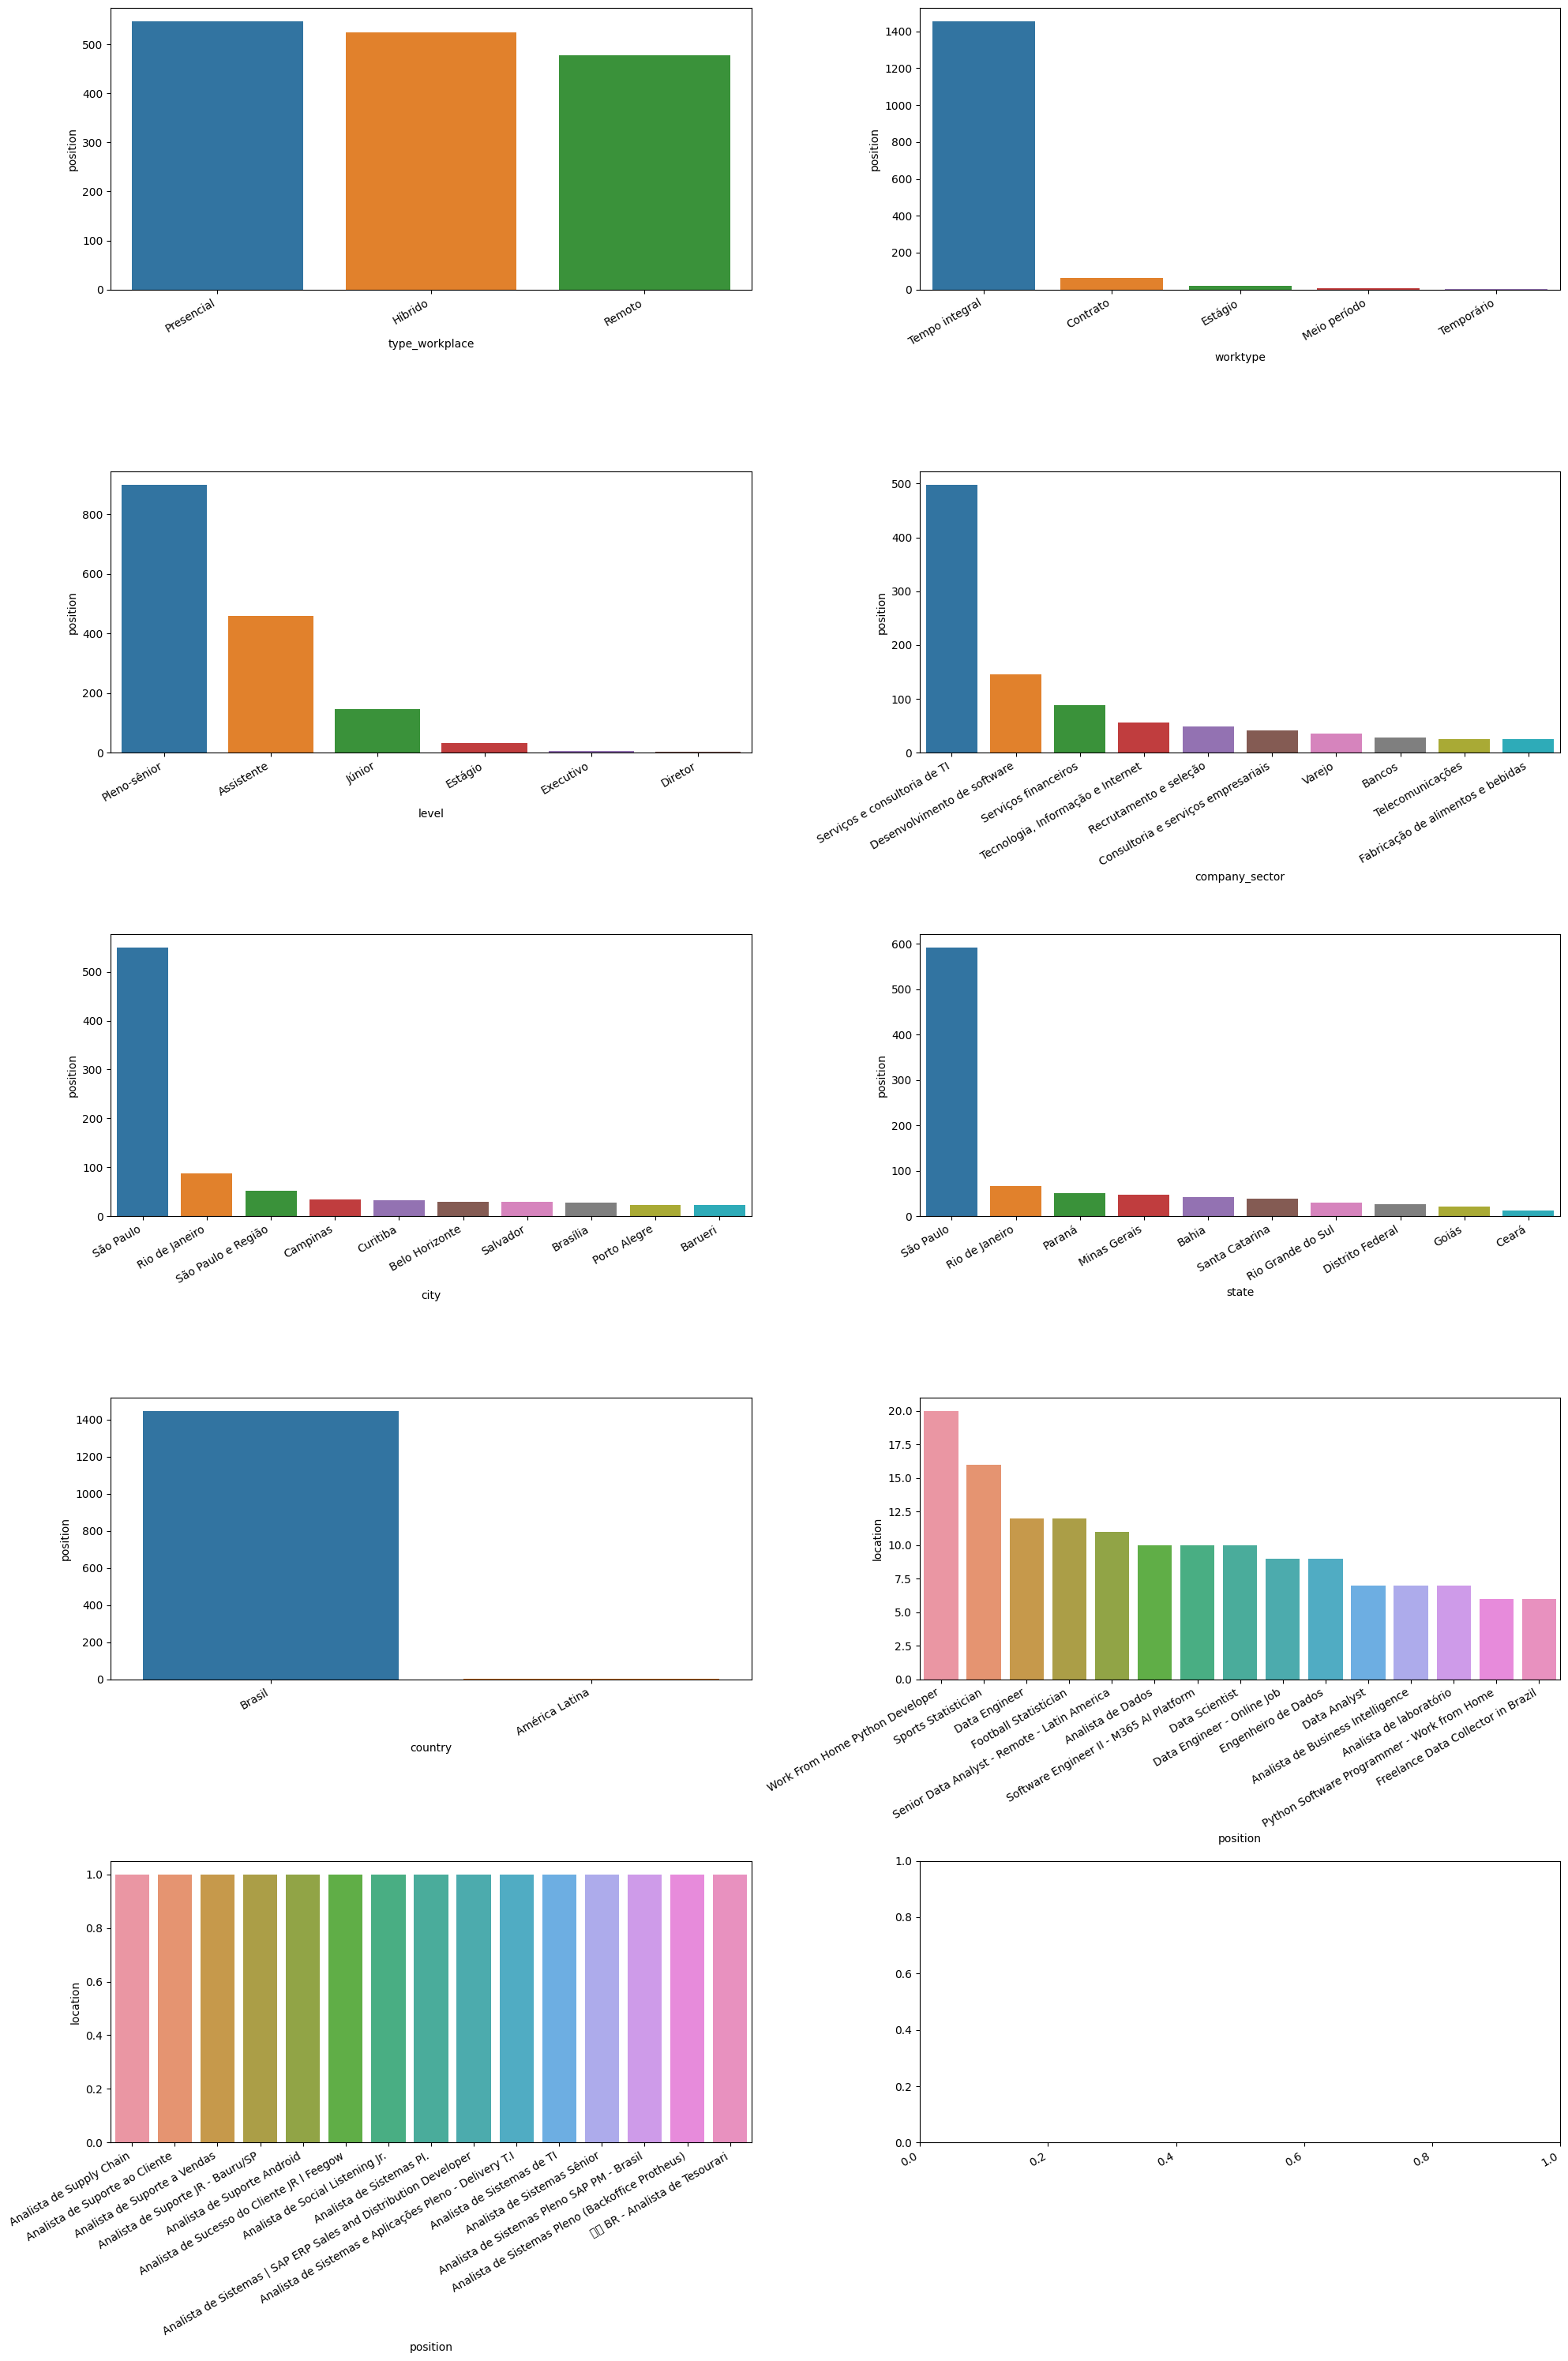

In [214]:
fig, ax = plt.subplots(5, 2, figsize=(20, 30))
sns.barplot(data=workplace_counts, x='type_workplace', y='position', ax=ax[0][0])
sns.barplot(data=worktype_counts, x='worktype', y='position', ax=ax[0][1])
sns.barplot(data=level_counts, x='level', y='position', ax=ax[1][0])
sns.barplot(data=company_sector_counts, x='company_sector', y='position', ax=ax[1][1])
sns.barplot(data=city_counts, x='city', y='position', ax=ax[2][0])
sns.barplot(data=state_counts, x='state', y='position', ax=ax[2][1])
sns.barplot(data=country_counts, x='country', y='position', ax=ax[3][0])
sns.barplot(data=position_counts, x='position', y='location', ax=ax[3][1])
sns.barplot(data=position_counts_end, x='position', y='location', ax=ax[4][0])
for i in ax:
    for j in i:
        plt.setp(j.get_xticklabels(), rotation=30, horizontalalignment='right')
fig.tight_layout()

<Axes: xlabel='posted_date', ylabel='position'>

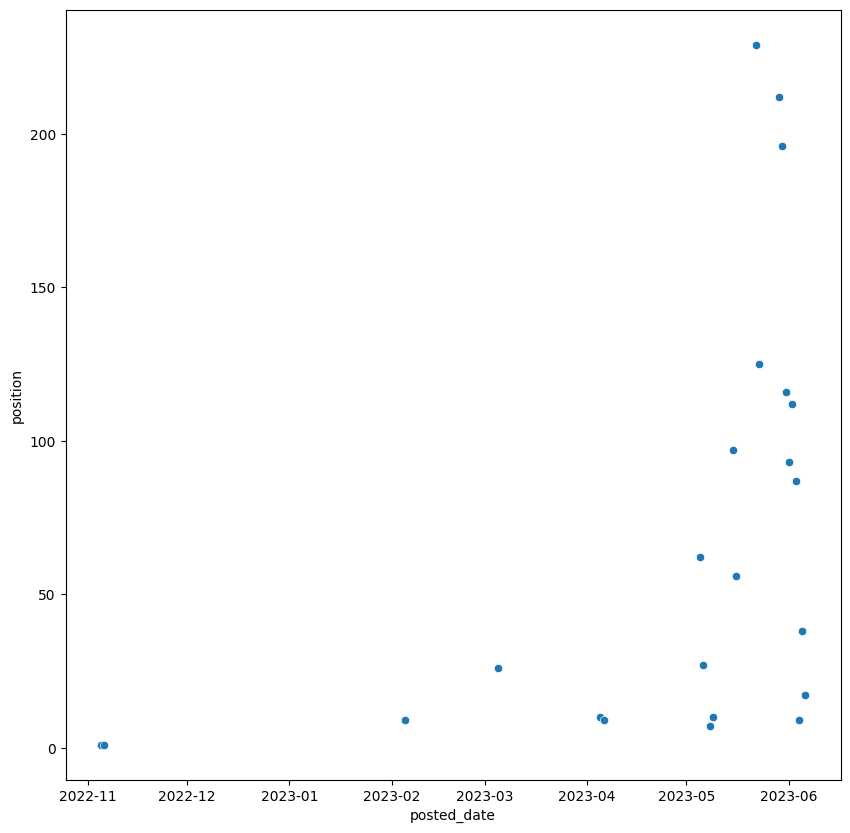

In [215]:
fig, _ = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(df_jobs.groupby('posted_date')['position'].count())

<Axes: xlabel='position', ylabel='posted_date'>

C:\Users\alexa\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:89: UserWarning: Glyph 127463 (\N{REGIONAL INDICATOR SYMBOL LETTER B}) missing from current font.
  func(*args, **kwargs)
C:\Users\alexa\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:89: UserWarning: Glyph 127479 (\N{REGIONAL INDICATOR SYMBOL LETTER R}) missing from current font.
  func(*args, **kwargs)
C:\Users\alexa\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:89: UserWarning: Glyph 9917 (\N{SOCCER BALL}) missing from current font.
  func(*args, **kwargs)
C:\Users\alexa\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127463 (\N{REGIONAL INDICATOR SYMBOL LETTER B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\alexa\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127479 (\N{REGIONAL INDICATOR SYMBOL LETTER R}) missing from 

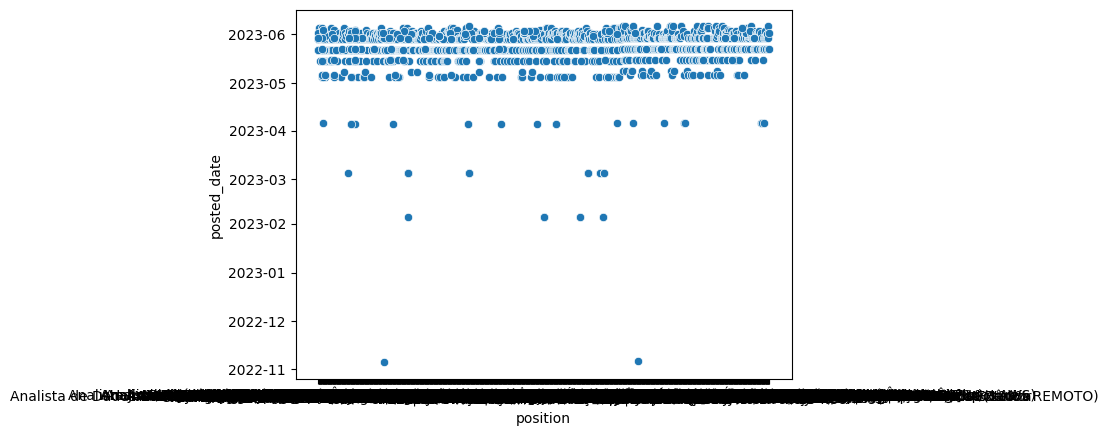

In [216]:
sns.scatterplot(data=df_jobs, x=df_jobs['position'], y=df_jobs['posted_date'])

<Axes: xlabel='posted_date', ylabel='no_applicants'>

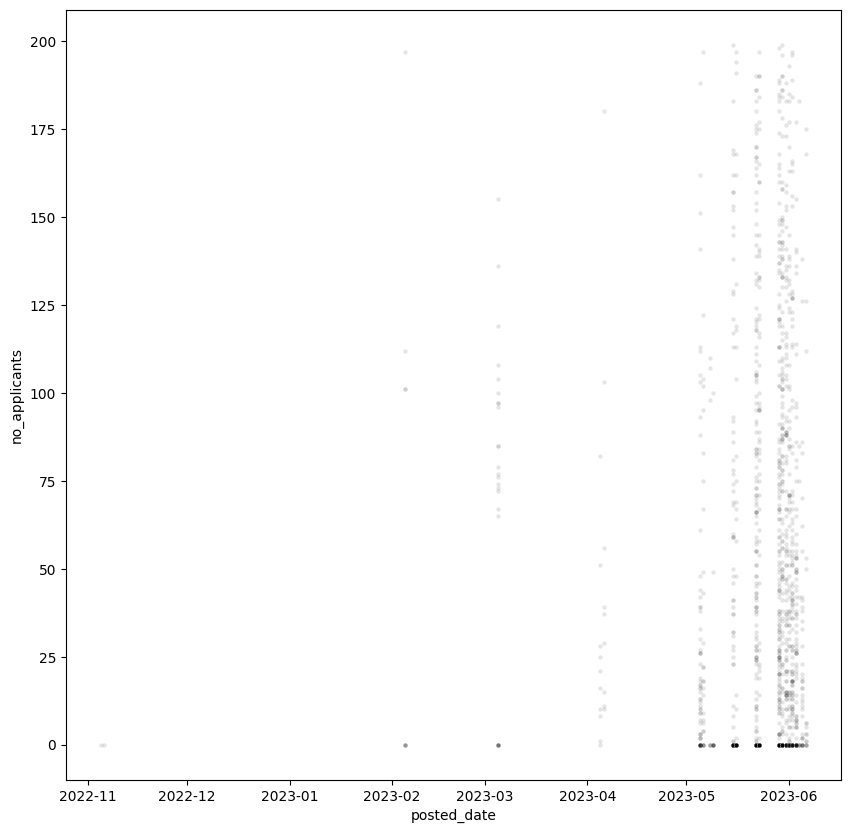

In [217]:
plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(data=df_jobs, x='posted_date', y='no_applicants', s=10, color='black', alpha=0.1)

## Skill Exploring

In [218]:
df_exploded_skills = df_jobs['required_skills'].dropna().map(lambda x: eval(x)).explode().reset_index()

In [219]:
df_exploded_skills

,index,required_skills
0,2,Esportes
1,2,Futebol americano
2,2,Inglês
3,2,Internet Access
4,2,Setor de esportes
...,...,...
14425,4479,JQuery
14426,4479,MES
14427,4479,Tecnologias da web
14428,4479,XML


<Axes: xlabel='index', ylabel='required_skills'>

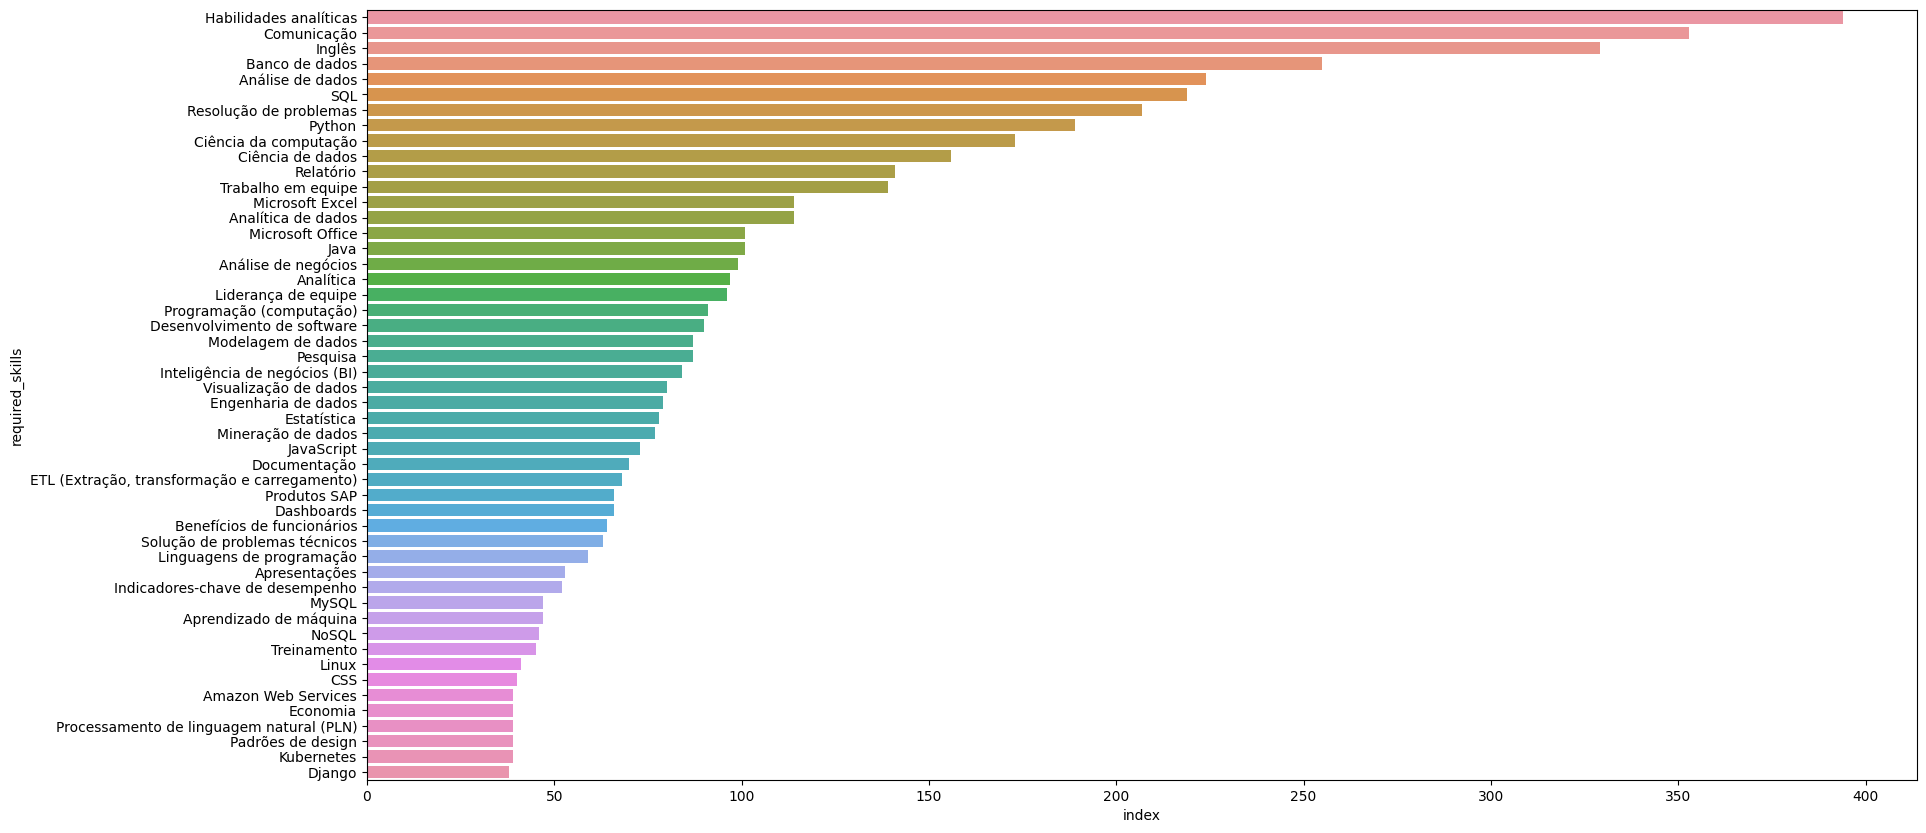

In [220]:
fig, ax = plt.subplots(figsize=(20,10))
plt.rcParams.update({'font.size': 15})
counted_skills = df_exploded_skills.groupby('required_skills').count().reset_index()
counted_skills = counted_skills.sort_values(by='index', ascending=False)
sns.barplot(data=counted_skills.head(50), y='required_skills', x='index', ax=ax)

In [221]:
print(len(counted_skills))
print(len(counted_skills[counted_skills['index'] > 1]))
print(len(counted_skills[counted_skills['index'] > 2]))
print(len(counted_skills[counted_skills['index'] > 3]))
print(len(counted_skills[counted_skills['index'] > 4]))
print(len(counted_skills[counted_skills['index'] > 5]))
print(len(counted_skills[counted_skills['index'] > 6]))
print(len(counted_skills[counted_skills['index'] > 7]))
print(len(counted_skills[counted_skills['index'] > 8]))
print(len(counted_skills[counted_skills['index'] > 9]))
print(len(counted_skills[counted_skills['index'] > 10]))

2667
1330
886
667
521
436
368
313
273
244
225


In [222]:
counted_skills[counted_skills['index'] > len(counted_skills) * 0.05]

,required_skills,index
1219,Habilidades analíticas,394
479,Comunicação,353
1320,Inglês,329
297,Banco de dados,255
135,Análise de dados,224
2223,SQL,219
2149,Resolução de problemas,207
1998,Python,189
420,Ciência da computação,173
421,Ciência de dados,156


In [223]:
counted_skills[counted_skills['index'] > len(counted_skills) * 0.01]

,required_skills,index
1219,Habilidades analíticas,394
479,Comunicação,353
1320,Inglês,329
297,Banco de dados,255
135,Análise de dados,224
...,...,...
932,Estruturas de dados,27
1662,Node.js,27
2058,Reconhecimento de padrões,27
902,Espanhol,27


In [224]:
counted_skills = counted_skills.rename({'index':'count'}, axis=1)

In [225]:
counted_skills['percentage_count'] = counted_skills['count'] / len(counted_skills)

In [226]:
counted_skills[counted_skills['percentage_count'] > 0.01]

,required_skills,count,percentage_count
1219,Habilidades analíticas,394,0.147732
479,Comunicação,353,0.132358
1320,Inglês,329,0.123360
297,Banco de dados,255,0.095613
135,Análise de dados,224,0.083990
...,...,...,...
932,Estruturas de dados,27,0.010124
1662,Node.js,27,0.010124
2058,Reconhecimento de padrões,27,0.010124
902,Espanhol,27,0.010124


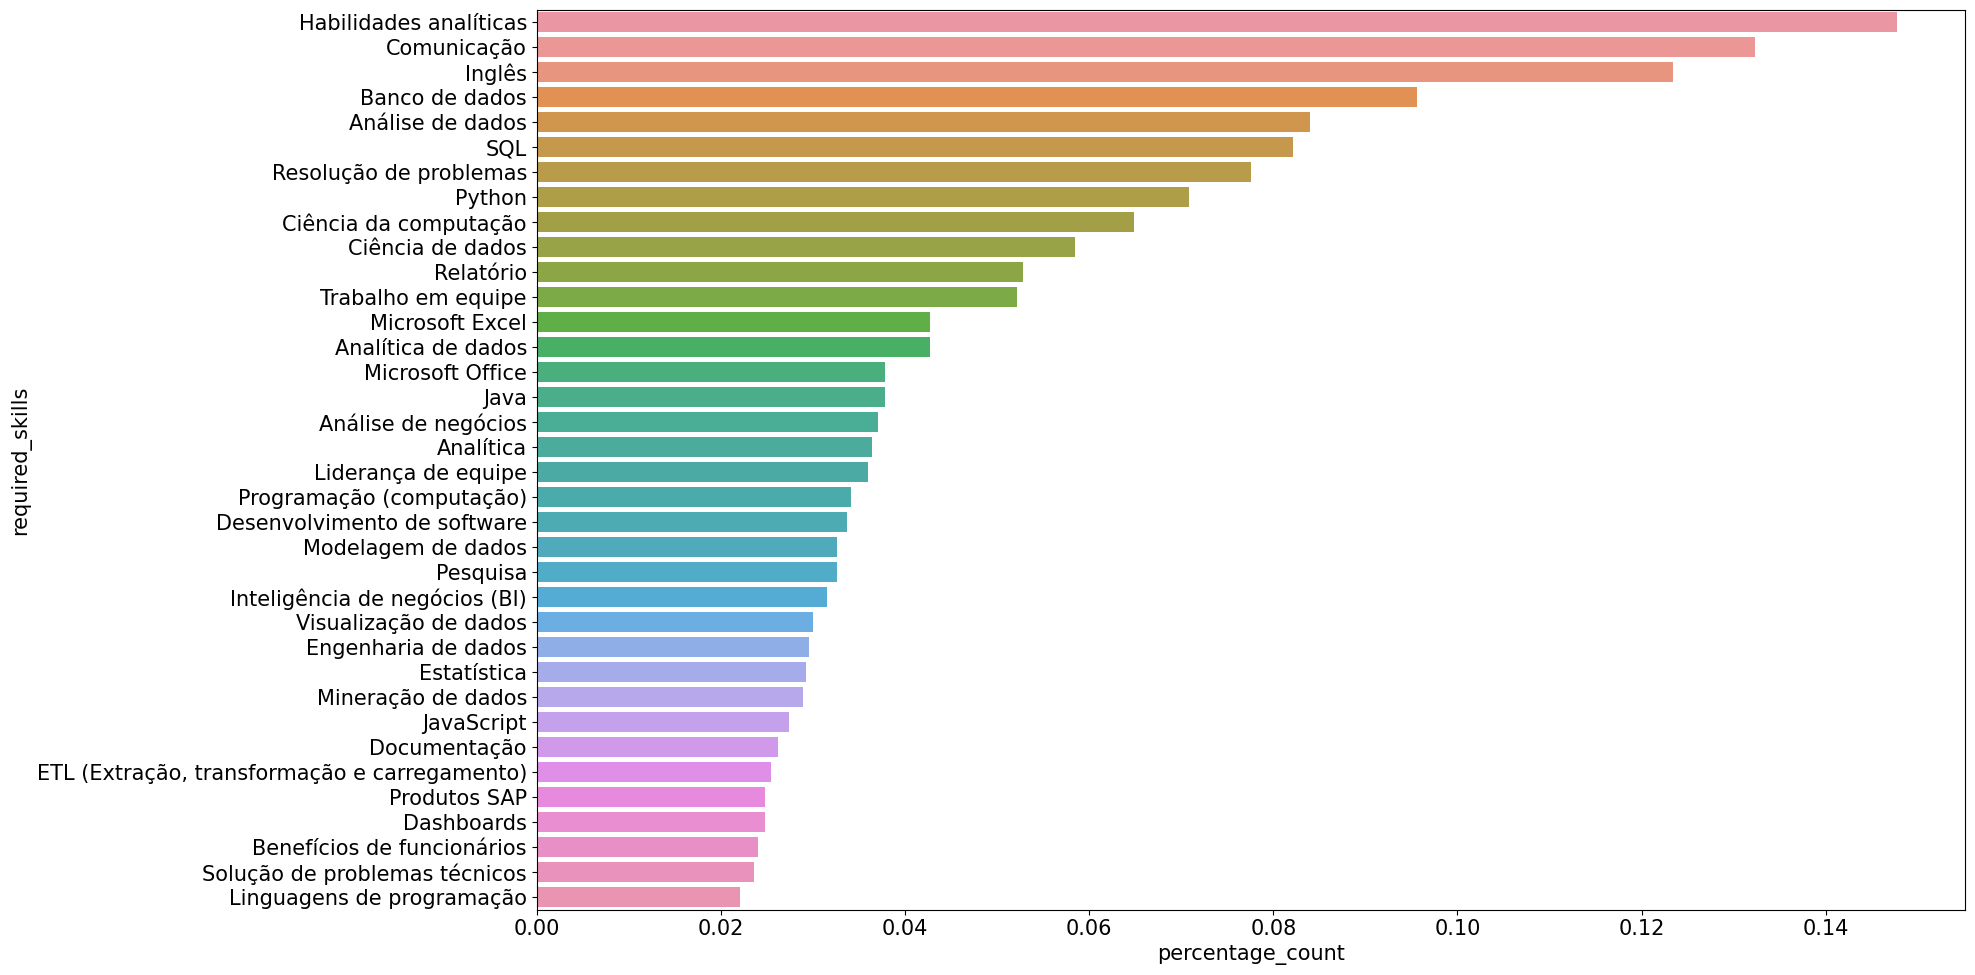

In [227]:
plt.subplots(figsize=(20,10))
sns.barplot(data=counted_skills[counted_skills['percentage_count'] > 0.02], y='required_skills', x='percentage_count')
plt.tight_layout()

In [228]:
df_jobs_merged = pd.merge(df_jobs, pd.get_dummies(df_exploded_skills).reset_index().groupby('index').sum(), how='inner', left_index=True, right_on='index').reset_index()

In [229]:
df_jobs_merged.columns[0:20]

Index(['index', 'position', 'location', 'posted_date', 'no_applicants',
       'date_collected', 'type_workplace', 'required_skills', 'level',
       'worktype', 'description', 'link_application', 'link_linkedin',
       'company_name', 'company_size', 'company_sector', 'city', 'state',
       'country', 'level_0'],
      dtype='object')

In [230]:
df_jobs_merged.type_workplace.value_counts()

type_workplace
Presencial    547
Híbrido       524
Remoto        478
Name: count, dtype: int64

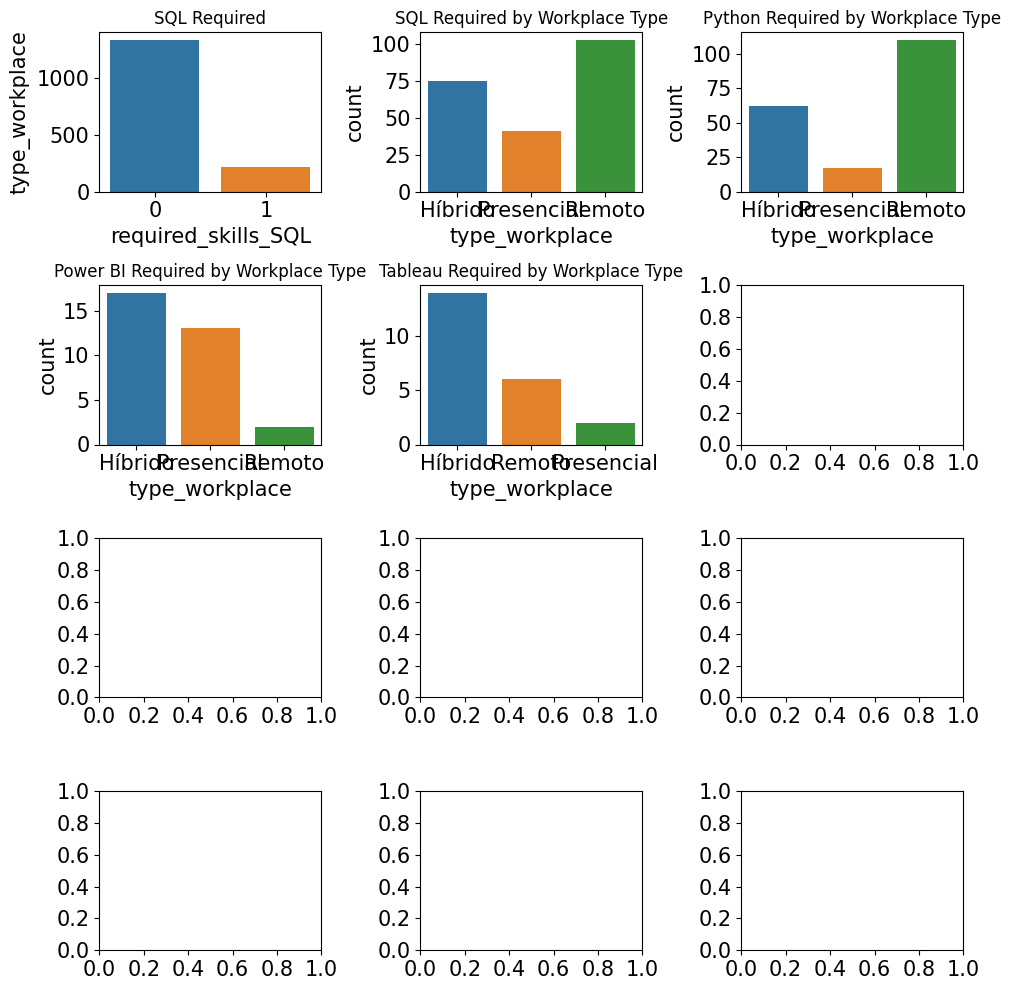

In [231]:
fig, ax = plt.subplots(4, 3, figsize=(10, 10))
plt.rcParams.update({'font.size': 10})

sql_count = df_jobs_merged.groupby('required_skills_SQL')['type_workplace'].count().reset_index()
mask_required_sql = df_jobs_merged['required_skills_SQL'] == True
mask_required_python = df_jobs_merged['required_skills_Python'] == True
mask_required_powerbi = df_jobs_merged['required_skills_Microsoft Power BI'] == True
mask_required_tableau = df_jobs_merged['required_skills_Tableau'] == True

sns.barplot(sql_count, x='required_skills_SQL', y='type_workplace', ax=ax[0][0])
ax[0][0].set_title('SQL Required')

sns.countplot(df_jobs_merged[mask_required_sql], x='type_workplace', ax=ax[0][1])
ax[0][1].set_title('SQL Required by Workplace Type')

sns.countplot(df_jobs_merged[mask_required_python], x='type_workplace', ax=ax[0][2])
ax[0][2].set_title('Python Required by Workplace Type')

sns.countplot(df_jobs_merged[mask_required_powerbi], x='type_workplace', ax=ax[1][0])
ax[1][0].set_title('Power BI Required by Workplace Type')

sns.countplot(df_jobs_merged[mask_required_tableau], x='type_workplace', ax=ax[1][1])
ax[1][1].set_title('Tableau Required by Workplace Type')

plt.tight_layout()


In [232]:
df_jobs_merged['link_application'].iloc[1]

'https://www.linkedin.com/jobs/view/3609349269/?alternateChannel=search&refId=tCWVCdLmkJlTrZ5vCMuj9w%3D%3D&trackingId=acRNtyGf5OzKhq7YSYU7GQ%3D%3D&trk=d_flagship3_search_srp_jobs'

In [233]:
import re
def process_url(url):
    url = url.split('//')[1].split('/')[0].replace('www.', '')
    if '.gupy.io' in url:
        return 'gupy.io'
    if '.infojobs.com.br' in url:
        return 'infojobs.com.br'
    return url

df_jobs_merged['link_application_simplified'] = df_jobs_merged.link_application.map(process_url)

<Axes: xlabel='index', ylabel='link_application_simplified'>

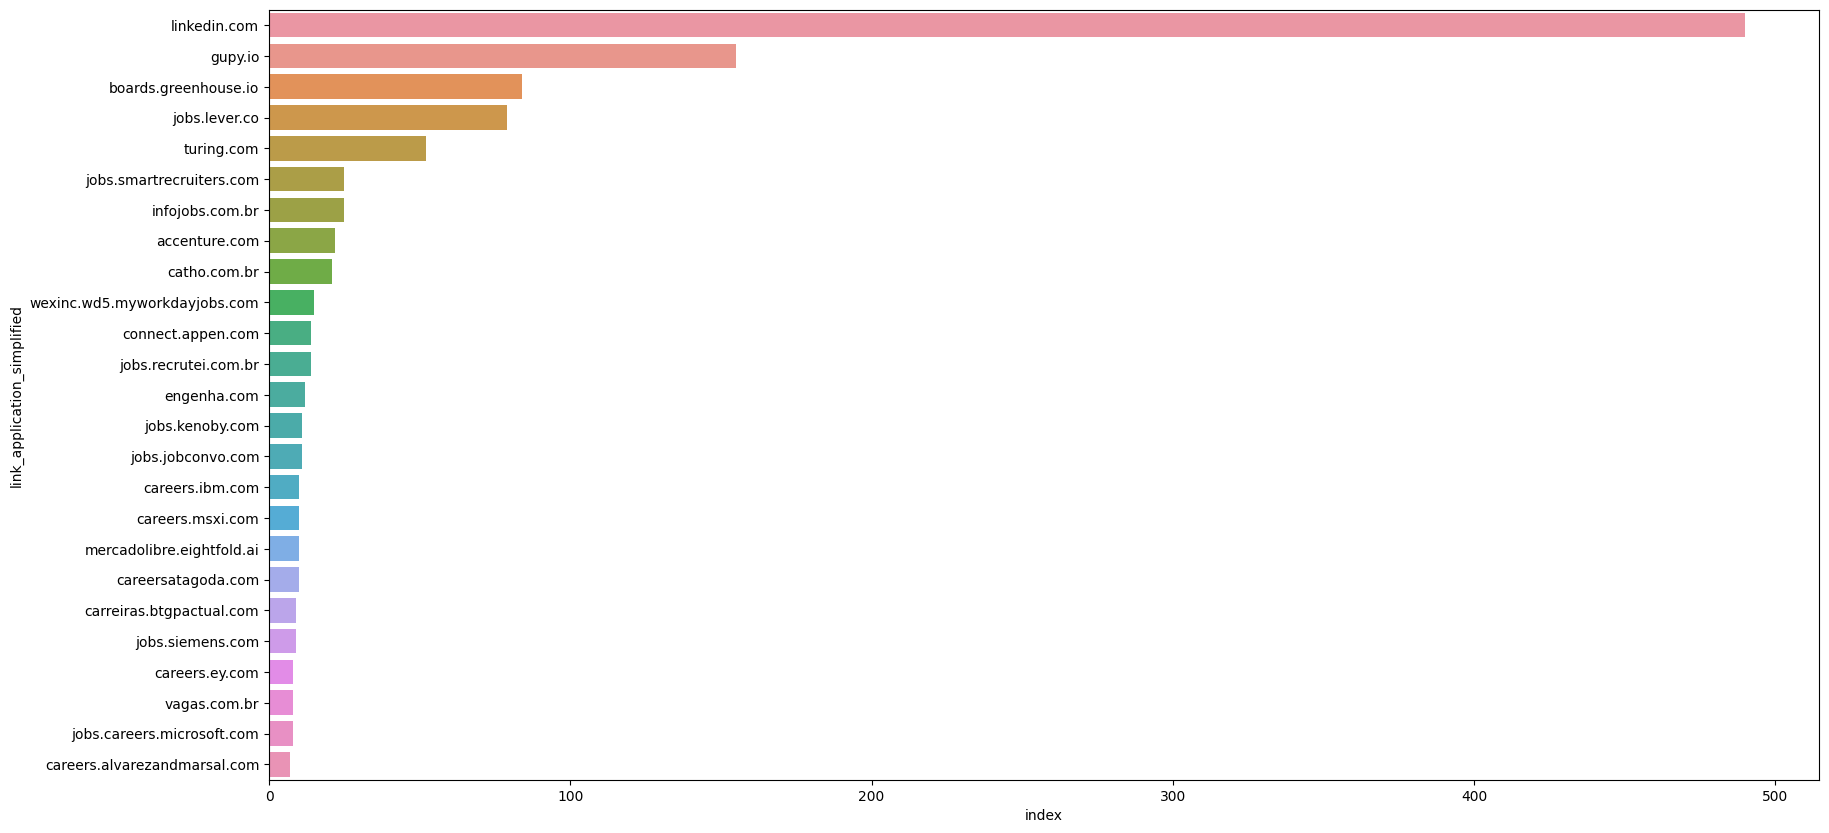

In [234]:
plt.subplots(figsize=(20, 10))
sns.barplot(data=df_jobs_merged.groupby('link_application_simplified').count().reset_index().sort_values(by='index', ascending=False).head(25), y='link_application_simplified', x='index')